# Sentiment Analysis on Social Media Data
This project involves analyzing the sentiment of social media data to understand public opinion on a particular topic. The dataset used is a collection of tweets related to a specific topic, and the goal is to classify the sentiment of each tweet as positive, negative, or neutral.
The project involves the following steps:
1. **Data Preprocessing**: Cleaning and preprocessing the data to remove unnecessary characters, punctuation, and special characters.
2. **Tokenization**: Breaking down the text into individual words or tokens.
3. **Stopword Removal**: Removing common words like "the", "and", etc. that do not add much value to the sentiment analysis.
4. **Stemming or Lemmatization**: Reducing words to their base form to reduce dimensionality.
5. **Feature Extraction**: Extracting features from the preprocessed text data using techniques like bag-of-words or TF-IDF.
6. **Model Selection**: Choosing a suitable machine learning model for sentiment analysis, such as Naive Bayes, Logistic Regression, or Support Vector Machines.
7. **Model Training**: Training the selected model on the preprocessed data.
8. **Model Evaluation**: Evaluating the performance of the trained model using metrics like accuracy, precision, recall, and F1-score.

### Import Required Dependences

In [59]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### Load Dataset

In [60]:
twitter_data = pd.read_csv('Data/Twitter_Data.csv')
reddit_data = pd.read_csv('Data/Reddit_Data.csv')

In [61]:
print(f"Twitter Data Size:{twitter_data.shape}")
print(f"Reddit Data Size:{reddit_data.shape}")

Twitter Data Size:(162980, 2)
Reddit Data Size:(37249, 2)


In [62]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [63]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


### Data Preprocessing

In [64]:
reddit_data = reddit_data.rename(columns={'clean_comment': 'clean_text'})

In [65]:
data = pd.concat([twitter_data, reddit_data], axis=0)
data.shape

(200229, 2)

In [66]:
data.drop_duplicates(inplace=True)

In [67]:
data.shape

(199718, 2)

In [68]:
data.nunique()

clean_text    199715
category           3
dtype: int64

In [69]:
data.isnull().sum()

clean_text    3
category      7
dtype: int64

In [70]:
data = data.dropna()

In [71]:
data['category'] = data['category'].map({-1: 0, 0: 1, 1: 2})

array([[<Axes: title={'center': 'category'}>]], dtype=object)

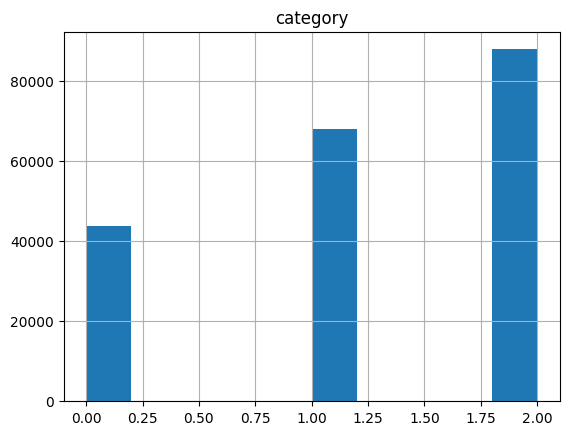

In [72]:
data.hist()

It seems like the dataset is not balanced. The number of samples in the `positive` class is much higher than the number of samples in the `neutral` class which is higher than the number of samples in the `negative` class. This could lead to biased results in the model.

### Data Splitting

In [73]:
train_data = data['clean_text']
test_data = data['category']
X_train, X_test, y_train, y_test = train_test_split(train_data, test_data, test_size=0.1, random_state=42, stratify=test_data, shuffle=True)

In [74]:
print(f"Size of X train: {X_train.shape}")
print(f"Size of Y train: {y_train.shape}")
print(f"Size of X test: {X_test.shape}")
print(f"Size of Y test: {y_test.shape}")

Size of X train: (179737,)
Size of Y train: (179737,)
Size of X test: (19971,)
Size of Y test: (19971,)


### Stopword Removal

In [75]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
def clean_text(text):
    """Function to clean text data"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

In [77]:
data['clean_text'] = data['clean_text'].apply(clean_text)

### Feature Extraction

In [78]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Handling the Imbalanced Dataset

In [79]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

### Model Training & Evaluation

In [80]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced')

In [81]:
y_pred = model.predict(X_test_tfidf)

In [82]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9304
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      4376
           1       0.93      0.98      0.95      6796
           2       0.95      0.92      0.94      8799

    accuracy                           0.93     19971
   macro avg       0.92      0.93      0.92     19971
weighted avg       0.93      0.93      0.93     19971



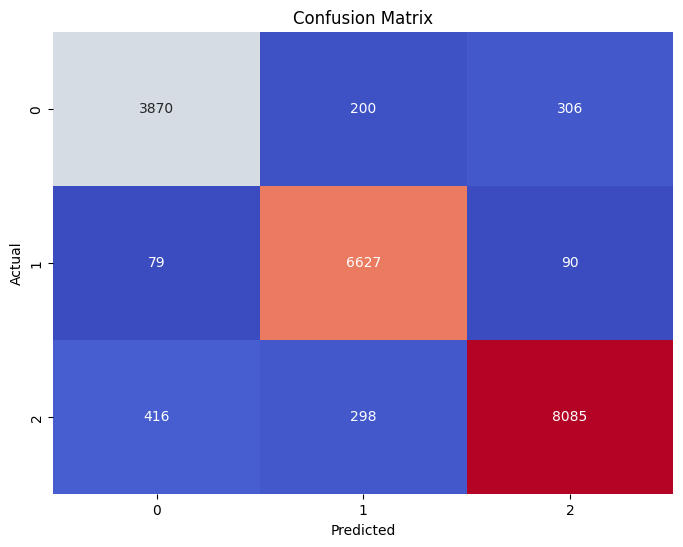

In [83]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix")
plt.show()

### Saving the Model

In [84]:
joblib.dump(model, "saved_models/logisticRegression.joblib")

['saved_models/logisticRegression.joblib']